In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

## Feature engineering

In [16]:
def handle_missing_values(df):  
    df_clean = df.copy()
    
    # Create missing flags
    df_clean['missing_playlist'] = df_clean['PLAYLIST_STREAM_PW'].isna().astype(int)
    df_clean['missing_userstats'] = df_clean['PLAYLIST_STREAM_USERSTATS_MAVG'].isna().astype(int)
    
    # Impute with median for missing < 35%
    numeric_cols = [
        'PLAYLIST_STREAM_PW',
        'PLAYLIST_USERSTATS_AVG_MAVG',
        'P_EXIT_USERS',
        'DISTINCT_USERS']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Impute with 0 for missing > 65%
    df_clean['PLAYLIST_STREAM_USERSTATS_MAVG'] = df_clean['PLAYLIST_STREAM_USERSTATS_MAVG'].fillna(0)
    
    return df_clean

def create_core_features(df):
    from sklearn.feature_extraction.text import TfidfVectorizer
    import pandas as pd
    
    df_features = df.copy()
    
    # Time features
    df_features['hour'] = df_features['CREATED_AT'].dt.hour
    df_features['is_peak_time'] = df_features['hour'].isin([5, 6, 7, 8]).astype(int)  # Best engagement 5-8 AM
    df_features['is_weekend'] = (df_features['CREATED_AT'].dt.dayofweek >= 5).astype(int)  # Saturday/Sunday
    
    # Platform features
    # Platforms with best engagement (from EDA)
    premium_platforms = ['iphone', 'android', 'hisense', 'viziovia', 'vizio']
    df_features['is_premium_platform'] = df_features['CLIENT_OS'].isin(premium_platforms).astype(int)
    
    # Content features
    df_features['is_short_video'] = (df_features['DURATION'] <= 180).astype(int)  # 1-3 min videos work better
    df_features['is_local_channel'] = (df_features['CHANNEL_TYPE'] == 'local').astype(int)  # Local > National
    
    # Authors with best engagement
    top_authors = ['amazelab', 'buzz60', 'deutschewelleenglish', 'kfor', 'wlax']
    df_features['is_top_author'] = df_features['STREAM_AUTHOR'].isin(top_authors).astype(int)
    
    # User behavior features
    # Personalization: channel AND tag favorites at same time
    df_features['both_favorites'] = ((df_features['IS_FAVORITE_CHANNEL'] == 1) & 
                                   (df_features['IS_FAVORITE_TAG'] == 1)).astype(int)
    
    # Low exit rate (users don't leave after video)
    df_features['low_exit_rate'] = (df_features['P_EXIT_USERS'] <= 0.3).astype(int)
    
    # Text features
    # Long titles
    df_features['title_length'] = df_features['TITLE'].str.len()
    df_features['has_long_title'] = (df_features['title_length'] > 50).astype(int)
    
    # Extract top 5 words from text
    try:
        tfidf = TfidfVectorizer(max_features=5, stop_words='english')
        text_combined = (df_features['TITLE'].fillna('') + ' ' + df_features['DESCRIPTION'].fillna('')).str.lower()
        
        tfidf_matrix = tfidf.fit_transform(text_combined)
        top_words = [f"has_{word}" for word in tfidf.get_feature_names_out()]
        
        # Convert to binary: has word or not
        word_features = (tfidf_matrix > 0).astype(int)
        tfidf_df = pd.DataFrame(word_features.toarray(), columns=top_words)
        
        # Add text features to main DataFrame
        df_features = pd.concat([df_features.reset_index(drop=True), 
                               tfidf_df.reset_index(drop=True)], axis=1)
        
        print(f"Text features added: {len(top_words)} words + 2 basic features")
    
    except Exception as e:
        print(f"Error processing text: {e}")
        print("Continuing without text features")
    
    # Target variable
    df_features['target'] = (df_features['ACTION'] == 'LIKE').astype(int)
    
    print(f"Total features created: {df_features.shape[1] - df.shape[1]}")
    
    return df_features

def select_model_features(df):
    import numpy as np
    
    all_features = [col for col in df.columns if col != 'target']
    feature_data = df[all_features].select_dtypes(include=[np.number])
    
    print(f"Analyzing {len(feature_data.columns)} numeric variables")
    
    # Detect high correlations (>0.85)
    corr_matrix = feature_data.corr().abs()
    
    # Remove correlated variables
    to_remove = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.85:
                feature_to_remove = corr_matrix.columns[j]
                if feature_to_remove not in to_remove:
                    to_remove.append(feature_to_remove)
                    print(f"Removing {feature_to_remove} (correlation {corr_matrix.iloc[i, j]:.3f} with {corr_matrix.columns[i]})")
    
    final_features = [f for f in feature_data.columns if f not in to_remove]
    print(f"Final features: {len(final_features)}")
    
    return final_features

## Execution

Feature Engineering Pipeline
Input shape: (344800, 18)
Missing values handled. Remaining: 0
Text features added: 5 words + 2 basic features
Total features created: 17
Features created. New shape: (344800, 37)
Analyzing 28 numeric variables
Removing missing_userstats (correlation 0.969 with PLAYLIST_STREAM_USERSTATS_MAVG)
Final features: 27
Selected 27 features for modeling
Data saved to 'data_processed.parquet'


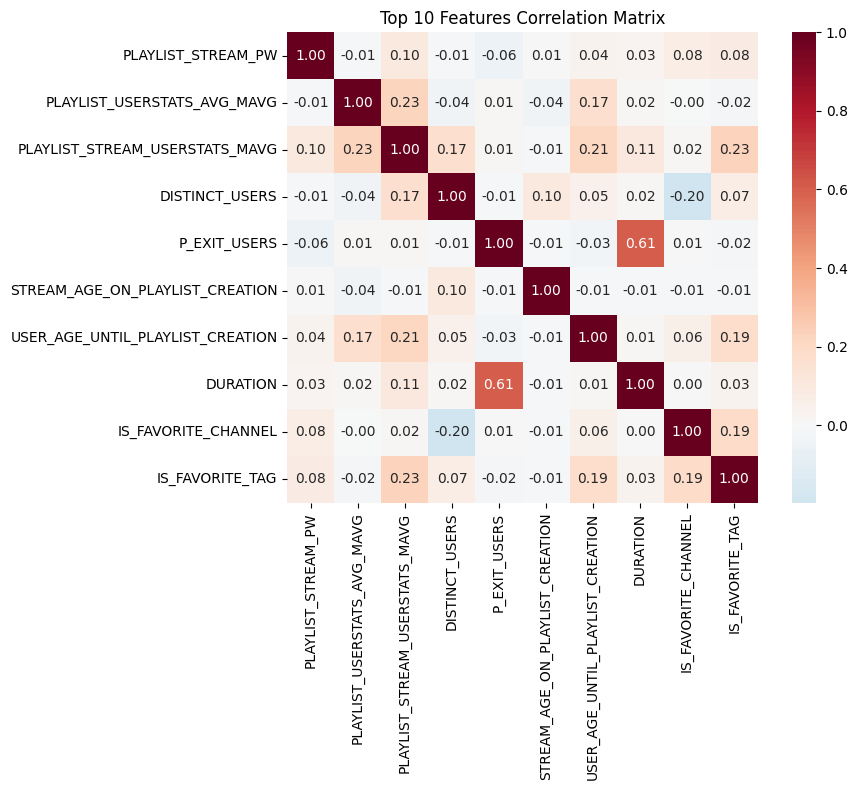


Pipeline completed successfully!
Final dataset shape: (344800, 37)
Selected features: 27
Files generated:
- data_processed.parquet
- feature_heatmap.png


In [28]:
def run_feature_engineering(df):    
    print("Feature Engineering Pipeline")
    print(f"Input shape: {df.shape}")
    
    # 1. Handle missing values
    df_clean = handle_missing_values(df)
    print(f"Missing values handled. Remaining: {df_clean.isnull().sum().sum()}")
    
    # 2. Create features
    df_features = create_core_features(df_clean)
    print(f"Features created. New shape: {df_features.shape}")
    
    # 3. Select final features
    model_features = select_model_features(df_features)
    print(f"Selected {len(model_features)} features for modeling")
    
    # 4. Save processed data
    df_features.to_parquet('data_processed.parquet', compression='gzip')
    print("Data saved to 'data_processed.parquet'")


    top_10_features = model_features[:10]  # First 10 features
    correlation_matrix = df_features[top_10_features].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', square=True)
    plt.title('Top 10 Features Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
        
    return df_features, model_features

if __name__ == "__main__":
    import pandas as pd
    
    # Load raw data
    df = pd.read_parquet("./../data/raw/sample_data.parquet.gzip")
    
    # Run complete pipeline
    df_processed, features = run_feature_engineering(df)
    
    print(f"\nPipeline completed successfully!")
    print(f"Final dataset shape: {df_processed.shape}")
    print(f"Selected features: {len(features)}")
    print("Files generated:")
    print("- data_processed.parquet")
    print("- feature_heatmap.png")